# **1.Conectamos Colab con Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
PATH_ORIGEN = "/content/drive/MyDrive/Electivos/IAA/Proyecto/code/dataset/BraTS-2020"
os.chdir(PATH_ORIGEN)
PATH_METRICS = "./DatasetFinal/processed/train/"
PATH_VAL = "./DatasetFinal/processed/valid/"
sys.path.append(os.path.abspath(PATH_ORIGEN))

In [3]:
!pip install tensorflow==2.1.0
!pip install keras==2.3.1

     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 450kB 39.0MB/s 
     |████████████████████████████████| 3.9MB 68.9MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=7511aedb3f4ddfa13ded0b0432cd5555bf0fa02f0bf09812ee9f11d6ecfdcec3
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninsta

In [4]:
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import h5py
import scipy
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
import visualization
import patch
import model1
import generate
import preprocessing
import metrics
import seg_eval_wt

Using TensorFlow backend.


In [5]:
print(tf.__version__)
print(keras.__version__)
## 2.1.0
## 2.3.1

2.1.0
2.3.1


# **2.Definimos el modelo**

## **2.1.Función de pérdida**

In [6]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):


    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean((dice_numerator)/(dice_denominator))
    
    return dice_loss

## **2.2.Métrica**

In [7]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):
    

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = K.mean((dice_numerator)/(dice_denominator))
    
    return dice_coefficient

## **2.3.Arquitectura**

In [8]:
model = model1.unet_model_3d(loss_function=soft_dice_loss, metrics=[dice_coefficient])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 160, 160, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 160, 160, 3488        input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 64, 160, 160, 55360       conv3d[0][0]                     
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 64, 80, 80, 8 0           conv3d_1[0][0]                   
______________________________________________________________________________________________

## **2.4.Entrenando**

Colocar el siguiente código JavaScript en la consola del navegador que este usando para que Colab no se desconecte por tiempo de inactividad,además no olvidar de apagar la opción de hibernación de su computadora local.


```
function ClickConnect(){

console.log("Working"); 

document.querySelector("colab-toolbar-button#connect").click() 

}

setInterval(ClickConnect,60000)

```



In [10]:
base_dir = PATH_ORIGEN + "/DatasetFinal/processed/"

with open(base_dir + "config.json") as json_file:
    config = json.load(json_file)

In [11]:
PATH_WEIGHTS = "./pesos/UNet3D/Epoch-114-XX/"

In [ ]:
# Checkpoint
model_checkpoint = ModelCheckpoint(filepath = PATH_WEIGHTS + "model-{epoch:04d}-{val_loss:.4f}.hdf5", 
                                   monitor = 'val_loss',
                                   verbose = 1, 
                                   save_best_only = False,
                                   #save_weights_only=False,
                                   save_freq = 'epoch'
                                   )
# History
csv_logger = CSVLogger(PATH_WEIGHTS + "model_history_log.csv", append=True)

In [17]:
# Generando dataset de entrenamiento y validacion
train_generator = generate.VolumeDataGenerator(config["train"], 
                                           base_dir + "train/", 
                                           batch_size=8, 
                                           dim=(160, 160, 16), 
                                           verbose=0)
valid_generator = generate.VolumeDataGenerator(config["valid"], 
                                            base_dir + "valid/", 
                                            batch_size=8, 
                                            dim=(160, 160, 16), 
                                            verbose=0)

In [ ]:
steps_per_epoch = 16
n_epochs = 7
validation_steps = 16

In [ ]:
history = model.fit_generator(generator=train_generator,
                steps_per_epoch = steps_per_epoch,
                epochs = n_epochs,
                callbacks=[model_checkpoint,csv_logger],
                use_multiprocessing=True,
                validation_data=valid_generator,
                validation_steps=validation_steps)

## **2.5.Cargamos el modelo**

In [12]:
# Cargar la ruta del punto de control q se desea recuperar
checkpoint_filepath ="pesos/UNet3D/Epoch-114-117/model-0004-0.1919.hdf5"

In [13]:
# Cargamos los pesos
model.load_weights(checkpoint_filepath)

# **3.Métricas**

## **3.1.Soft dice loss y dice coefficient**

In [14]:
PATH_HISTORY = "./pesos/UNet3D/history_final.csv"
history = pd.read_csv(PATH_HISTORY)

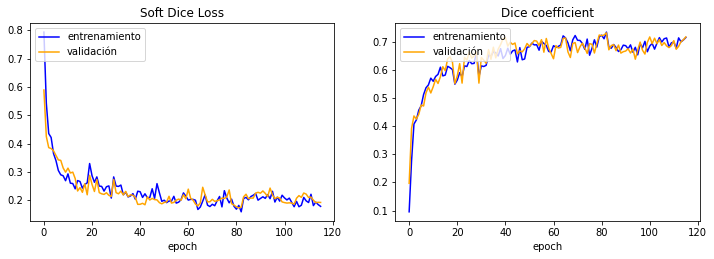

In [15]:
# GRAFICANDO resultados
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(12, 8)

# plot loss
plt.subplot(2,2,1)
plt.title('Soft Dice Loss')
plt.xlabel("epoch")
plt.plot(history['loss'], color='blue', label='train')
plt.plot(history['val_loss'],color ='orange',label='validation')
plt.legend(['entrenamiento', 'validación'], loc='upper left')

# plot dice coefficient
plt.subplot(2,2,2)
plt.title('Dice coefficient')
plt.xlabel("epoch")
plt.plot(history['dice_coefficient'], color='blue', label='train')
plt.plot(history['val_dice_coefficient'], color='orange', label='validation')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

In [18]:
val_loss, val_dice = model.evaluate_generator(valid_generator)
print(f"validation soft dice loss: {val_loss:.4f}")
print(f"validation dice coefficient: {val_dice:.4f}")

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
validation soft dice loss: 0.1986
validation dice coefficient: 0.7093


# **4.Visualización del dataset de validación**

In [28]:
image, label = preprocessing.load_case("DatasetFinal/imagesTr/train/BraTS20_Training_002_total.nii", 
                         "DatasetFinal/labelsTr/train/BraTS20_Training_002_segf.nii")

In [29]:
start_x,start_y,start_z,X,y = preprocessing.get_sub_volume(image,label)

In [30]:
X_norm = preprocessing.standardize(X)

(array([0., 1.], dtype=float32), array([406786,   2814]))


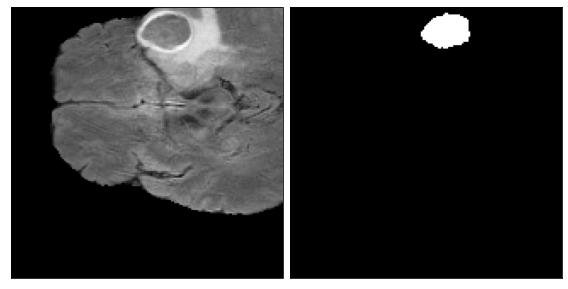

In [31]:
# NUCLEO DEL TUMOR
visualization.visualize_patch(X_norm[0, :, :, :], y[0])
print(np.unique(y[0],return_counts=True))

(array([0., 1.], dtype=float32), array([389533,  20067]))


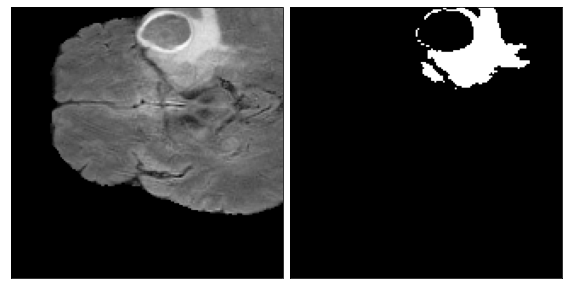

In [32]:
# EDEMA PERITUMORAL
visualization.visualize_patch(X_norm[0, :, :, :], y[1])
print(np.unique(y[1],return_counts=True))

(array([0., 1.], dtype=float32), array([407096,   2504]))


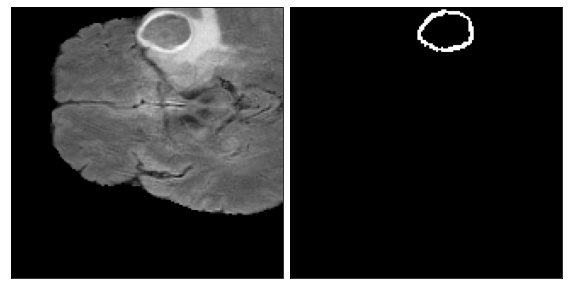

In [33]:
# TUMOR REALZADO
visualization.visualize_patch(X_norm[0, :, :, :], y[2])
print(np.unique(y[2],return_counts=True))

In [34]:
# Prediccion sobre la validacion
# Agregamos una dimension mas --> X_norm debe ser de la forma(batch_size,num_channels,x_dim,y_dim,z_dim)
X_norm_with_batch_dimension = np.expand_dims(X_norm, axis=0)
print(X_norm_with_batch_dimension.shape)

(1, 4, 160, 160, 16)


In [35]:
# Prediccion
patch_pred = model.predict(X_norm_with_batch_dimension)
print(patch_pred.shape)

(1, 3, 160, 160, 16)


# **5.Inferencia**

In [36]:
# Umbral para la predicción
threshold = 0.5
patch_pred[patch_pred > threshold] = 1.0  # clase tumor
patch_pred[patch_pred <= threshold] = 0.0 # clase no tumor

## **5.1.Métricas**

Dado el umbral de predicción de la red neuronal se procederá a calcular el accuracy,precision y recall.

In [37]:
accuracy_TC,precision_TC,recall_TC,dice_TC = metrics.metric_class(patch_pred[0],y,0) # Nucleo del tumor
accuracy_ED,precision_ED,recall_ED,dice_ED = metrics.metric_class(patch_pred[0],y,1) # Edema peritumoral
accuracy_ET,precision_ET,recall_ET,dice_ET = metrics.metric_class(patch_pred[0],y,2)  # tumor realzado

In [38]:
patch_metrics = metrics.get_metrics_df(patch_pred[0],y)
patch_metrics

,Nucleo del tumor,Edema peritumoral,Tumor realzado
Accuracy,0.9971,0.9877,0.9969
Sensitivity,0.9325,0.8774,0.7692
Specificity,0.9976,0.9934,0.9983
Dice,0.8164,0.8746,0.7519


In [ ]:
PATH_METRICS = "/content/drive/MyDrive/Electivos/IAA/Proyecto/code/dataset/BraTS-2020/DatasetFinal/processed/train/"

In [ ]:
#a,b,c = metrics.metric_class(patch_pred[0],y,0)
#print(a,b,c)
print(metrics.metric_class(patch_pred[0],y,0)[0])
print(metrics.metric_class(patch_pred[0],y,0)[1])
print(metrics.metric_class(patch_pred[0],y,0)[2])
print(metrics.metric_class(patch_pred[0],y,0)[3])

0.99791015625
0.8213002286834368
0.999239925320818
0.8545207341944255


In [ ]:
PATH_VAL = "./DatasetFinal/processed/valid/"

In [20]:
validation = config['valid']

In [21]:
### Métricas globales ####
### Accuracy,Precision,Recall y Dice por cada máscara ####
accuracy_TC =[]
accuracy_WT =[]
accuracy_ET =[]

sensibilidad_TC =[]
sensibilidad_WT =[]
sensibilidad_ET =[]

especificidad_TC =[]
especificidad_WT =[]
especificidad_ET = []

dice_TC =[]
dice_WT =[]
dice_ET =[]

long_valid = len(validation)

for i in tqdm(range(long_valid)):
  ruta = PATH_VAL + str(validation[i])
  with h5py.File(ruta, 'r') as f:

    data_x = f.get('x')
    data_y = f.get('y')

    X = np.array(data_x)
    y = np.array(data_y)
    y = np.moveaxis(y, 3, 0)[1:] # Excluimos la máscara de WT

    X_norm = preprocessing.standardize(X)
    X_norm_with_batch_dimension = np.expand_dims(X_norm, axis=0)
    patch_pred = model.predict(X_norm_with_batch_dimension)

    # Umbral
    threshold = 0.5
    patch_pred[patch_pred > threshold] = 1.0  # clase tumor
    patch_pred[patch_pred <= threshold] = 0.0 # clase no tumor

    # Hallamos el tumor completo como la suma de las máscaras

    # Para la máscara verdadera
    y_WT = y[0] + y[1] + y[2]
    y_WT = np.where(y_WT >= 1, 1, 0)

    # Para la máscara predicha
    patch_pred_WT = patch_pred[0,0, :, :, :] + patch_pred[0,1, :, :, :] + patch_pred[0,2, :, :, :]
    patch_pred_WT = np.where(patch_pred_WT >= 1, 1, 0)

    # Métricas
    a1,b1,c1,d1 = metrics.metric_class(patch_pred[0],y,0) # Accuracy,sensibilidad,especificidad y dice para TC
    #a2,b2,c2,d2 = metrics.metric_class(patch_pred[0],y,1) # Accuracy,sensibilidad,especificidad y dice para ED
    a2,b2,c2,d2 = seg_eval_wt.metric_class(patch_pred_WT,y_WT) # Accuracy,sensibilidad,especificidad y dice para WT
    a3,b3,c3,d3 = metrics.metric_class(patch_pred[0],y,2) # Accuracy,sensibilidad,especificidad y dice para ET

    accuracy_TC.append(round(a1,3)) 
    accuracy_WT.append(round(a2,3)) 
    accuracy_ET.append(round(a3,3)) 

    sensibilidad_TC.append(round(b1,3)) 
    sensibilidad_WT.append(round(b2,3)) 
    sensibilidad_ET.append(round(b3,3)) 

    especificidad_TC.append(round(c1,3)) 
    especificidad_WT.append(round(c2,3))
    especificidad_ET.append(round(c3,3))

    dice_TC.append(round(d1,3))
    dice_WT.append(round(d2,3))
    dice_ET.append(round(d3,3))

  3%|▎         | 37/1290 [00:27<14:40,  1.42it/s]/content/drive/.shortcut-targets-by-id/1LhjoA4gUbfSsTM8dqU3VR-wSCJXZt5nQ/Electivos/IAA/Proyecto/code/dataset/BraTS-2020/metrics.py:39: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = (tp) / (tp + fn)
  4%|▍         | 49/1290 [00:36<15:23,  1.34it/s]/content/drive/.shortcut-targets-by-id/1LhjoA4gUbfSsTM8dqU3VR-wSCJXZt5nQ/Electivos/IAA/Proyecto/code/dataset/BraTS-2020/metrics.py:41: RuntimeWarning: invalid value encountered in long_scalars
  dice = (2*tp) /((2*tp)+fp+fn)
100%|██████████| 1290/1290 [18:08<00:00,  1.19it/s]


In [22]:
accuracy_TC_final = round(pd.Series(accuracy_TC).dropna().mean(),3) # Nucleo del tumor
accuracy_WT_final = round(pd.Series(accuracy_WT).dropna().mean(),3) # Edema peritumoral
accuracy_ET_final = round(pd.Series(accuracy_ET).dropna().mean(),3) # Tumor realzado

sensibilidad_TC_final = round(pd.Series(sensibilidad_TC).dropna().mean(),3) 
sensibilidad_WT_final = round(pd.Series(sensibilidad_WT).dropna().mean(),3)
sensibilidad_ET_final = round(pd.Series(sensibilidad_ET).dropna().mean(),3)

especificidad_TC_final = round(pd.Series(especificidad_TC).dropna().mean(),3) 
especificidad_WT_final = round(pd.Series(especificidad_WT).dropna().mean(),3)
especificidad_ET_final = round(pd.Series(especificidad_ET).dropna().mean(),3)

dice_TC_final = round(pd.Series(dice_TC).dropna().mean(),3)
dice_WT_final = round(pd.Series(dice_WT).dropna().mean(),3)
dice_ET_final = round(pd.Series(dice_ET).dropna().mean(),3)

In [23]:
acc = [accuracy_TC_final,accuracy_WT_final,accuracy_ET_final]
sens =[sensibilidad_TC_final,sensibilidad_WT_final,sensibilidad_ET_final]
spec =[especificidad_TC_final,especificidad_WT_final,especificidad_ET_final]
dice =[dice_TC_final,dice_WT_final,dice_ET_final]

In [24]:
metrics_final = pd.DataFrame(columns = ['Nucleo del tumor', 'Tumor completo', 'Tumor realzado'], index = ['Sensibilidad','Especificidad','Dice'])
    
for i, class_name in enumerate(metrics_final.columns):
    #metrics_final.loc['Accuracy', class_name] = acc[i]
    metrics_final.loc['Sensibilidad', class_name] = sens[i]
    metrics_final.loc['Especificidad', class_name] = spec[i]
    metrics_final.loc['Dice', class_name] = dice[i]

In [25]:
# Métricas finales del dataset de validación
metrics_final

,Nucleo del tumor,Tumor completo,Tumor realzado
Sensibilidad,0.515,0.841,0.763
Especificidad,0.997,0.997,0.997
Dice,0.515,0.886,0.705


# **6.Visualización de inferencia**

## **6.1.Para cada máscara**

In [39]:
# valor real de los pixeles
print(y.shape)
print(np.unique(y[0],return_counts=True)) # Nucleo del tumor
print(np.unique(y[1],return_counts=True)) # Edema peritumoral
print(np.unique(y[2],return_counts=True)) # Tumor realzado

(3, 160, 160, 16)
(array([0., 1.], dtype=float32), array([406786,   2814]))
(array([0., 1.], dtype=float32), array([389533,  20067]))
(array([0., 1.], dtype=float32), array([407096,   2504]))


In [40]:
# Valor predicho de los pixeles
print(patch_pred[0,:,:,:].shape)
print(np.unique(patch_pred[0,0, :, :, :],return_counts=True)) # Nucleo del tumor
print(np.unique(patch_pred[0,1, :, :, :],return_counts=True)) # Edema peritumoral
print(np.unique(patch_pred[0,2, :, :, :],return_counts=True)) # Tumor realzado

(3, 160, 160, 16)
(array([0., 1.], dtype=float32), array([405986,   3614]))
(array([0., 1.], dtype=float32), array([389406,  20194]))
(array([0., 1.], dtype=float32), array([406981,   2619]))


Segmentacion real


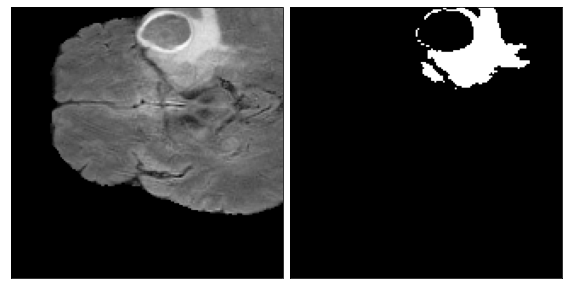

Segmentacion Unet


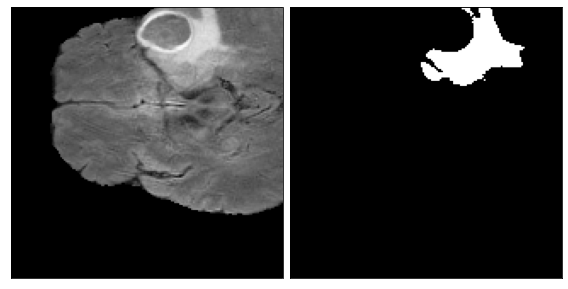

In [43]:
# X_norm :(secuencia,alto,ancho,profundidad)
# y: máscara (0->TC, 1->EDEMA, 2->ET)
print("Segmentacion real")  
visualization.visualize_patch(X_norm[0, :, :, :], y[1])
plt.show()
print("Segmentacion Unet")
visualization.visualize_patch(X_norm[0, :, :, :], patch_pred[0,1, :, :, :])
plt.show()

## **6.2.Para WT (Tumor completo)**

In [44]:
# Hallamos la máscara y_WT como la suma de las demás máscaras
y_WT = y[0] + y[1] + y[2]
y_WT = np.where(y_WT >= 1, 1, 0)

In [45]:
# Hallamos la predicción de la máscara y_WT como la suma de las demás máscaras
patch_pred_WT = patch_pred[0,0, :, :, :] + patch_pred[0,1, :, :, :] + patch_pred[0,2, :, :, :]
patch_pred_WT = np.where(patch_pred_WT >= 1, 1, 0)

In [46]:
patch_pred_WT.shape

(160, 160, 16)

Segmentacion real WT


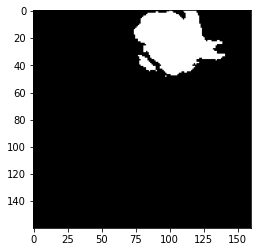

Segmentacion Unet WT


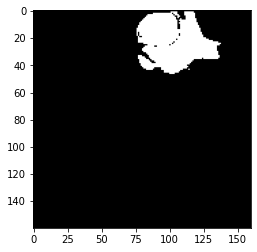

In [47]:
print("Segmentacion real WT")
plt.imshow(y_WT[:,:,0],cmap="gray")
plt.show()
print("Segmentacion Unet WT")
plt.imshow(patch_pred_WT[:,:,0],cmap="gray")
plt.show()

## **6.3.Para la IMR completa**

In [ ]:
image, label = preprocessing.load_case("DatasetFinal/imagesTr/train/BraTS20_Training_002_total.nii", 
                         "DatasetFinal/labelsTr/train/BraTS20_Training_002_segf.nii")

In [48]:
def predict_and_viz(image, label, model, threshold = 0.5):
    """
    Función encargada de realizar la segmentación total de la resonancia
    magnética :(240,240,155) , además genera un par de videos donde se compara
    la segmentación de un experto vs la hecha por la CNN

    Parameters
    ----------
    image : array con las 4 secuencias.
    label : array con las 3 máscaras
    model : red neuronal encargada de la predicción
    threshold: umbral para la clasificación
    Returns
    -------
    out: Video .mp4 en el que se observa los diversos cortes en el eje Z de la IMR
    para cada una de las máscaras (TC,ED,ET)

    out_wt: Video .mp4 en el que se observa los diversos cortes en el eje Z de la IMR
    para el tumor completo (WT)
    
    En ambos videos se muestra un versus de la segmentación realizada por la CNN y 
    la segmentación realizada por el experto.
    """
    image_labeled = visualization.get_labeled_image(image.copy(), label.copy())

    # Dimensiones del contenedor

    dim_1 = max([x+160 for x in range(0,image.shape[0],160)])
    dim_2 = max([y + 160 for y in range(0,image.shape[1],160)])
    dim_3 = max([z+16 for z in range(0,image.shape[2],16)])

    # Inicializamos el contenedor de la IMR completa

    model_label = np.zeros([3, dim_1, dim_2, dim_3]) #shape:(3,320,320,160)
    model_label_bin = np.zeros([3, dim_1, dim_2, dim_3]) #shape:(3,320,320,160)

    # Recorremos todos los subvolúmenes que se puedan generar
    # y los agregamos al contenedor principal
    for x in range(0, image.shape[0], 160):
        for y in range(0, image.shape[1], 160):
            for z in range(0, image.shape[2], 16):
                # Inicializamos el contenedor
                patch = np.zeros([4, 160, 160, 16])

                # Movemos el canal de las secuencias de la resonancia a la primera posicion
                p = np.moveaxis(image[x: x + 160, y: y + 160, z:z + 16], 3, 0)

                # Movemos el contenido de p a patch para que pueda ser procesado por la CNN
                patch[:, 0:p.shape[1], 0:p.shape[2], 0:p.shape[3]] = p

                # Predecimos sobre el bloque de tamaño :(3,160,160,16)
                pred = model.predict(np.expand_dims(patch, 0))

                # Inicializamos contenedor con las máscaras binarizadas
                pred_bin = pred
                pred_bin[pred_bin > threshold] = 1.0  # clase tumor
                pred_bin[pred_bin <= threshold] = 0.0 # clase no tumor

                # Agregamos la región predicha al contenedor principal
                model_label[:, x:x + p.shape[1], y:y + p.shape[2], z: z + p.shape[3]] += pred[0][:, :p.shape[1], :p.shape[2],:p.shape[3]]
                model_label_bin[:, x:x + p.shape[1], y:y + p.shape[2], z: z + p.shape[3]] += pred_bin[0][:, :p.shape[1], :p.shape[2],:p.shape[3]]


    # Damos la forma del label original : (3,240,240,155)
    model_label = np.moveaxis(model_label[:, 0:240, 0:240, 0:155], 0, 3)
    model_label_bin = np.moveaxis(model_label_bin[:, 0:240, 0:240, 0:155], 0, 3)
    # Nota: model_label almacena las máscaras(TC,ED,ET) en forma de RGB
    # y model_label_bin almacena las máscaras (TC,ED,ET) en formato de 0 y 1

    # Hallamos la predicción del tumor completo como la suma de las máscaras
    model_label_bin_WT = model_label_bin[:,:,:,0] + model_label_bin[:,:,:,1] + model_label_bin[:,:,:,2]

    # Máscara final predicha del tumor completo(WT)!!!!!!
    model_label_bin_WT = np.where(model_label_bin_WT >= 1, 1, 0)

    
    # Inicializamos el contenedor con 4 máscaras las cuales serán:
    # WT(verdadera) , TC,ED,ET (predichas por la CNN)
    model_label_reformatted = np.zeros((240, 240, 155, 4))
    model_label_bin_reformatted = np.zeros((240,240,155))

    # Guardamos la máscara del tumor completo
    model_label_reformatted = to_categorical(label, num_classes=4).astype(np.uint8)

    # Guardamos las máscaras predichas por la CNN(TC,ED,ET)
    model_label_reformatted[:, :, :, 1:4] = model_label

    # Guardamos la máscara verdadera del tumor completo(WT)
    model_label_bin_reformatted = model_label_reformatted[:,:,:,0]

    # Invertimos los valores de los pixeles ya que en TC están con valor de 0
    model_label_bin_reformatted = np.where(model_label_bin_reformatted==1,0,1) # Máscara final verdadera del WT!!!!!!


    # Secuencia FLAIR con las máscaras(TC,ED,ET)
    model_labeled_image = visualization.get_labeled_image(image, model_label_reformatted,
                                            is_categorical=True)
    
    # Secuencia FLAIR  con el tumor completo predicho(WT)!!!!!
    image_flair_wt = cv2.normalize(image[:, :, :, 0], None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)
    labeled_image_wt_pred = np.zeros_like(model_label_bin_WT)
    labeled_image_wt_pred = np.where(model_label_bin_WT==1,255,image_flair_wt)


    # Secuencia FLAIR  con el tumor completo verdadero(WT)!!!!
    labeled_image_wt_real = np.zeros_like(model_label_bin_reformatted)
    labeled_image_wt_real = np.where(model_label_bin_reformatted==1,255,image_flair_wt)

    #### Generamos videos y gif sobre el plano XY ####

    images = []
    images_bin =[]
    area_expert =[]
    area_cnn = []
    count = 0
    count_bin = 0
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    out = cv2.VideoWriter('Brats2020.mp4',fourcc, 10.0, (680,240))
    out_wt = cv2.VideoWriter('Brats2020_WT.mp4',fourcc, 10.0, (680,240),0)
    font = cv2.FONT_ITALIC

    #### Para las máscaras TC,ED,ET ####
    for i in range(model_labeled_image.shape[2]):
        pred = model_labeled_image[:, :, min(i, model_labeled_image.shape[2] - 1)] # (240,240,3)
        real = image_labeled[:, :, min(i, model_labeled_image.shape[2] - 1)] # (240,240,3)
        aux =  np.zeros([240, 200, 3]).astype(np.uint8)
        img = np.concatenate((real,pred,aux), axis=1)
        images.append(img)
    imageio.mimsave("./Brats2020.gif", images, duration=0.01)

    #### Para la máscara WT ####
    for j in range(labeled_image_wt_real.shape[2]):
        pred_wt = labeled_image_wt_pred[:, :, min(j, labeled_image_wt_real.shape[2] - 1)].astype(np.uint8) # (240, 240)
        real_wt = labeled_image_wt_real[:, :, min(j, labeled_image_wt_real.shape[2] - 1)].astype(np.uint8) # (240, 240)
        aux_wt =  np.zeros([240, 200]).astype(np.uint8)
        img_wt = np.concatenate((real_wt,pred_wt,aux_wt), axis=1)
        images_bin.append(img_wt)
    imageio.mimsave("./Brats2020_WT.gif", images_bin, duration=0.01)
  
  
    #### Para las máscaras TC,ED,ET ####
    for frame in images:
      cv2.putText(frame,"Experto", (85,30), 0, 0.8, (255,255,255))
      cv2.putText(frame,"Unet", (320,30), 0, 0.8, (255,255,255))
      cv2.putText(frame,str("Capa:") + str(count),(500,30),0,0.5,(255,255,255))

      cv2.putText(frame,str("Nucleo del tumor:"),(500,80),0,0.25,(255,255,255))
      cv2.rectangle(frame,pt1 = (600,70),pt2 =(620,90),color = (255,0,0),thickness = -1)

      cv2.putText(frame,str("Edema peritumoral:"),(500,140),0,0.25,(255,255,255))
      cv2.rectangle(frame,pt1 = (600,130),pt2 =(620,150),color = (0,255,0),thickness = -1)

      cv2.putText(frame,str("Tumor realzado:"),(500,200),0,0.25,(255,255,255))
      cv2.rectangle(frame,pt1 = (600,190),pt2 =(620,210),color = (0,0,255),thickness = -1)

      frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
      out.write(frame)
      count = count + 1
    out.release()

    #### Para la máscara WT ####
    for frame_bin in images_bin:

      cv2.putText(frame_bin,"Experto", (85,30), 0, 0.8, (255,255,255))
      cv2.putText(frame_bin,"Unet", (320,30), 0, 0.8, (255,255,255))
      cv2.putText(frame_bin,str("Capa:") + str(count_bin),(500,30),0,0.5,(255,255,255))

      cv2.putText(frame_bin,str("Tumor completo:"),(500,80),0,0.25,(255,255,255))
      cv2.rectangle(frame_bin,pt1 = (600,70),pt2 =(620,90),color = (255,255,255),thickness = -1)

      out_wt.write(frame_bin)
      count_bin = count_bin + 1
    out_wt.release()

    print("Videos guardados correctamente")

    return out,out_wt

In [ ]:
image_labeled = visualization.get_labeled_image(image.copy(), label.copy())

# Dimensiones del contenedor

dim_1 = max([x+160 for x in range(0,image.shape[0],160)])
dim_2 = max([y + 160 for y in range(0,image.shape[1],160)])
dim_3 = max([z+16 for z in range(0,image.shape[2],16)])

# Inicializamos el contenedor de la IMR completa

model_label = np.zeros([3, dim_1, dim_2, dim_3]) #shape:(3,320,320,160)
model_label_bin = np.zeros([3, dim_1, dim_2, dim_3]) #shape:(3,320,320,160)

# Recorremos todos los subvolúmenes que se puedan generar
# y los agregamos al contenedor principal
for x in range(0, image.shape[0], 160):
    for y in range(0, image.shape[1], 160):
        for z in range(0, image.shape[2], 16):
            # Inicializamos el contenedor
            patch = np.zeros([4, 160, 160, 16])

            # Movemos el canal de las secuencias de la resonancia a la primera posicion
            p = np.moveaxis(image[x: x + 160, y: y + 160, z:z + 16], 3, 0)

            # Movemos el contenido de p a patch para que pueda ser procesado por la CNN
            patch[:, 0:p.shape[1], 0:p.shape[2], 0:p.shape[3]] = p

            # Predecimos sobre el bloque de tamaño :(3,160,160,16)
            pred = model.predict(np.expand_dims(patch, 0))

            # Inicializamos contenedor con las máscaras binarizadas
            pred_bin = pred
            pred_bin[pred_bin > threshold] = 1.0  # clase tumor
            pred_bin[pred_bin <= threshold] = 0.0 # clase no tumor

            # Agregamos la región predicha al contenedor principal
            model_label[:, x:x + p.shape[1], y:y + p.shape[2], z: z + p.shape[3]] += pred[0][:, :p.shape[1], :p.shape[2],:p.shape[3]]
            model_label_bin[:, x:x + p.shape[1], y:y + p.shape[2], z: z + p.shape[3]] += pred_bin[0][:, :p.shape[1], :p.shape[2],:p.shape[3]]

# Damos la forma del label original : (3,240,240,155)
model_label = np.moveaxis(model_label[:, 0:240, 0:240, 0:155], 0, 3)
model_label_bin = np.moveaxis(model_label_bin[:, 0:240, 0:240, 0:155], 0, 3)
# Nota: model_label almacena las máscaras(TC,ED,ET) en forma de RGB
# y model_label_bin almacena las máscaras (TC,ED,ET) en formato de 0 y 1

# Hallamos la predicción del tumor completo como la suma de las máscaras
model_label_bin_WT = model_label_bin[:,:,:,0] + model_label_bin[:,:,:,1] + model_label_bin[:,:,:,2]

# Máscara final predicha del tumor completo(WT)!!!!!!
model_label_bin_WT = np.where(model_label_bin_WT >= 1, 1, 0)


# Inicializamos el contenedor con 4 máscaras las cuales serán:
# WT(verdadera) , TC,ED,ET (predichas por la CNN)
model_label_reformatted = np.zeros((240, 240, 155, 4))
model_label_bin_reformatted = np.zeros((240,240,155))

# Guardamos la máscara del tumor completo
model_label_reformatted = to_categorical(label, num_classes=4).astype(np.uint8)

# Guardamos las máscaras predichas por la CNN(TC,ED,ET)
model_label_reformatted[:, :, :, 1:4] = model_label

# Guardamos la máscara verdadera del tumor completo(WT)
model_label_bin_reformatted = model_label_reformatted[:,:,:,0]

# Invertimos los valores de los pixeles ya que en TC están con valor de 0
model_label_bin_reformatted = np.where(model_label_bin_reformatted==1,0,1) # Máscara final verdera del WT!!!!!!


# Secuencia FLAIR con las máscaras(TC,ED,ET)
model_labeled_image = visualization.get_labeled_image(image, model_label_reformatted,
                                        is_categorical=True)

# Secuencia FLAIR  con el tumor completo predicho(WT)!!!!!
image_flair_wt = cv2.normalize(image[:, :, :, 0], None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)
labeled_image_wt_pred = np.zeros_like(model_label_bin_WT)
labeled_image_wt_pred = np.where(model_label_bin_WT==1,255,image_flair_wt)
#labeled_image_wt_pred = labeled_image_wt_pred*255
#labeled_image_wt_pred = model_label_bin_WT*image_flair_wt


# Secuencia FLAIR  con el tumor completo verdadero(WT)!!!!
labeled_image_wt_real = np.zeros_like(model_label_bin_reformatted)
labeled_image_wt_real = np.where(model_label_bin_reformatted==1,255,image_flair_wt)
#labeled_image_wt_real = labeled_image_wt_real*255
#labeled_image_wt_real = model_label_bin_reformatted*image_flair_wt

In [ ]:
#### Grafico en forma de gif sobre el plano XY ####

images = []
images_bin =[]
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('newww.mp4',fourcc, 10.0, (680,240))
#out_wt = cv2.VideoWriter('new_wt.mp4',fourcc, 10.0, (480,240))
font = cv2.FONT_ITALIC

#### Para la máscara WT ####
for j in range(labeled_image_wt_real.shape[2]):
    pred_wt = labeled_image_wt_pred[:, :, min(j, labeled_image_wt_real.shape[2] - 1)].astype(np.uint8) # (240,240,3)
    real_wt = labeled_image_wt_real[:, :, min(j, labeled_image_wt_real.shape[2] - 1)].astype(np.uint8)# (240,240,3)
    img_wt = np.concatenate((pred_wt,real_wt), axis=1)
    images_bin.append(img_wt)
imageio.mimsave("./new_wt.gif", images_bin, duration=0.01)

In [49]:
image, label = preprocessing.load_case("DatasetFinal/imagesTr/train/BraTS20_Training_002_total.nii", 
                         "DatasetFinal/labelsTr/train/BraTS20_Training_002_segf.nii")
visualization.predict_and_viz(image, label, model, .5)

Videos guardados correctamente


(<VideoWriter 0x7fdf284bbf50>, <VideoWriter 0x7fdf285fee70>)

## **6.4.Visualización en forma de gif**

In [ ]:
def visualize_data_gif(pred,real):
    """
    Visualizacion de máscaras de segmentación en los diversos cortes
    de una resonancia magnética
    Parameters
    ----------
    data_ : Arreglo formado por píxeles de 0-255 , donde los píexeles 0 forman el tumor
    completo y los píxeles 1 dentro del bloque del tumor completo son las partes del tumor
    # Verde: edema peritumoral
    # Azul: tumor realzado
    # Rojo: nucleo del tumor

    Returns
    -------
    TYPE
        imagen en formato de gif
    """
    images = []
    for i in range(real.shape[2]):
        x = pred[:, :, min(i, real.shape[2] - 1)] # (240,240,3) # Plano XY--> pred
        # x = data_[min(i, data_.shape[0] - 1), :, :] # (240,155,3) # Plano YZ
        # y = data_[:, min(i, data_.shape[1] - 1), :] # (240,155,3) # Plano XZ
        z = real[:, :, min(i, real.shape[2] - 1)] # (240,240,3) # Plano XY--> real
        img = np.concatenate((x,z), axis=1)
        images.append(img)
    imageio.mimsave("./new.gif", images, duration=0.01)
    return 0